In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
import scipy.cluster.hierarchy as shc
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import tqdm

# Import/Format Data

In [2]:
data=pd.read_csv('data/patients.csv')
dataOG=pd.read_csv('data/patients.csv')
dfo=pd.read_csv('data/observations.csv')
data['BIRTHDATE']=data['BIRTHDATE'].str.replace('-', '')
data['SSN']=data['SSN'].str.replace('-', '')
data['BIRTHDATE']=data['BIRTHDATE'].astype(float)
data['SSN']=data['SSN'].astype(float)
data=data.drop(['Id','DEATHDATE','MAIDEN','DRIVERS','PASSPORT','PREFIX','FIRST','LAST','SUFFIX','BIRTHPLACE','ADDRESS','CITY','STATE','COUNTY'],axis=1)
data['MARITAL']=data['MARITAL'].fillna(0)
data['ZIP']=data['ZIP'].fillna(0)
data['MARITAL']=data['MARITAL'].replace({'M':1})
data['MARITAL']=data['MARITAL'].replace({'S':0})
data['GENDER']=data['GENDER'].replace({'M':1})
data['GENDER']=data['GENDER'].replace({'F':0})

## Shrink Observation Dataframe

In [3]:
dfo.shape

(299697, 8)

In [4]:
dfobmi=dfo.drop(dfo.loc[dfo["DESCRIPTION"]!="Body Mass Index"].index)
dfobw=dfo.drop(dfo.loc[dfo["DESCRIPTION"]!="Body Weight"].index)
dfobh=dfo.drop(dfo.loc[dfo["DESCRIPTION"]!="Body Height"].index)
dfodbp=dfo.drop(dfo.loc[dfo["DESCRIPTION"]!="Diastolic Blood Pressure"].index)
dfosbp=dfo.drop(dfo.loc[dfo["DESCRIPTION"]!="Systolic Blood Pressure"].index)
dfobhr=dfo.drop(dfo.loc[dfo["DESCRIPTION"]!="Heart rate"].index)
dfobrr=dfo.drop(dfo.loc[dfo["DESCRIPTION"]!="Respiratory rate"].index)
dfo=pd.concat([dfobmi,dfobw,dfobh,dfodbp,dfosbp,dfobhr,dfobrr])
dfo=dfo.sample(frac=1,random_state=6)
dfo.head()

,DATE,PATIENT,ENCOUNTER,CODE,DESCRIPTION,VALUE,UNITS,TYPE
135534,2012-09-22T10:26:36Z,69b60335-4bd9-4043-ad76-26b75d7dd40a,4ca1fa3d-0429-473f-9dd5-f942f071a137,8480-6,Systolic Blood Pressure,123.0,mm[Hg],numeric
206667,2013-07-06T13:13:50Z,78a9a8d6-b3b2-47dc-b4a0-867abec7c78f,1c2ef8a9-7d30-4634-8806-8d0326238c24,39156-5,Body Mass Index,27.2,kg/m2,numeric
111336,1989-07-29T20:06:53Z,59cf17d9-6c13-4333-a1cb-cc5fdf63366d,7b05a570-1969-4cdf-91c5-c26b6d28b80a,8302-2,Body Height,186.8,cm,numeric
12201,2016-03-04T04:10:32Z,dadd331c-6143-41d1-bffb-d34b321ed157,40a0cbb2-de8f-48fe-9f77-1315c17cb4c3,9279-1,Respiratory rate,12.0,/min,numeric
146886,1999-02-25T02:48:14Z,60320709-0445-4112-ab79-1997cc6f3822,db7ef447-a886-4522-882c-14f29fae6853,39156-5,Body Mass Index,27.5,kg/m2,numeric


In [5]:
dfo.shape

(87585, 8)

# Set Up Observation Data Frame

In [6]:
patient_ids=set()
for patient_id in dfo["PATIENT"]:
    patient_ids.add(patient_id)
patient_ids=list(patient_ids)
patient_ids.sort()

In [7]:
columns=["patient_id","Body Height","Body Weight", "Body Mass Index","Diastolic Blood Pressure",
         "Systolic Blood Pressure","Heart rate","Respiratory rate"]
global dfm
dfm=pd.DataFrame(columns=columns)
dfm["patient_id"]=patient_ids
dfm.head()

,patient_id,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate
0,00185faa-2760-4218-9bf5-db301acf8274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0042862c-9889-4a2e-b782-fac1e540ecb4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0047123f-12e7-486c-82df-53b3a450e365,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010d4a3a-2316-45ed-ae15-16f01c611674,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01207ecd-9dff-4754-8887-4652eda231e2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Populate Dataframe

In [8]:
query=pd.DataFrame()
for column in columns[1:]:
    query=pd.concat([query,dfo.query(f"DESCRIPTION=='{column}'")])

In [9]:
for index_dfo,row_dfo in tqdm.tqdm(list(query[["PATIENT","DESCRIPTION","VALUE"]].iterrows())):
    if row_dfo["DESCRIPTION"] in columns:
        dfm.loc[dfm.patient_id==row_dfo["PATIENT"],row_dfo["DESCRIPTION"]]= row_dfo["VALUE"]

100%|██████████| 87585/87585 [02:45<00:00, 528.26it/s]


In [10]:
dfm.head()

,patient_id,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate
0,00185faa-2760-4218-9bf5-db301acf8274,153.2,55.5,18.0,75.0,127.0,94.0,13.0
1,0042862c-9889-4a2e-b782-fac1e540ecb4,91.1,16.2,14.6,78.0,119.0,66.0,13.0
2,0047123f-12e7-486c-82df-53b3a450e365,176.5,87.6,28.1,70.0,118.0,76.0,13.0
3,010d4a3a-2316-45ed-ae15-16f01c611674,143.1,53.7,29.2,74.0,136.0,63.0,12.0
4,01207ecd-9dff-4754-8887-4652eda231e2,62.4,3.8,NaN,75.0,136.0,79.0,13.0


# Merge Patient/observation Dataframe

In [11]:
data.head()

,BIRTHDATE,SSN,MARITAL,RACE,ETHNICITY,GENDER,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
0,19890525.0,999766866.0,1,white,hispanic,1,1013.0,42.228354,-72.562951,271227.08,1334.88
1,19831114.0,999735361.0,1,white,nonhispanic,1,2143.0,42.360697,-71.126531,793946.01,3204.49
2,19920602.0,999273385.0,1,white,nonhispanic,1,1020.0,42.181642,-72.608842,574111.90,2606.40
3,19780527.0,999854926.0,1,white,nonhispanic,0,1851.0,42.636143,-71.343255,935630.30,8756.19
4,19961018.0,999607372.0,0,white,nonhispanic,1,2135.0,42.352434,-71.028610,598763.07,3772.20


In [12]:
df=pd.concat([data,dfm],axis=1)
df=df.drop(['patient_id','SSN','LAT','LON'],axis=1)
df.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate
0,19890525.0,1,white,hispanic,1,1013.0,271227.08,1334.88,153.2,55.5,18.0,75.0,127.0,94.0,13.0
1,19831114.0,1,white,nonhispanic,1,2143.0,793946.01,3204.49,91.1,16.2,14.6,78.0,119.0,66.0,13.0
2,19920602.0,1,white,nonhispanic,1,1020.0,574111.90,2606.40,176.5,87.6,28.1,70.0,118.0,76.0,13.0
3,19780527.0,1,white,nonhispanic,0,1851.0,935630.30,8756.19,143.1,53.7,29.2,74.0,136.0,63.0,12.0
4,19961018.0,0,white,nonhispanic,1,2135.0,598763.07,3772.20,62.4,3.8,NaN,75.0,136.0,79.0,13.0


In [13]:
dfcopy=df.copy()
dfcopy=dfcopy.dropna()
dfcopy=dfcopy.sample(frac=1, random_state=7896)
dfcopy.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate
1032,20050924.0,0,white,nonhispanic,1,0.0,334857.07,2949.00,181.4,112.2,34.1,80.0,109.0,71.0,13.0
1016,19730910.0,1,white,nonhispanic,0,2635.0,82207.01,4264.81,177.4,89.1,28.3,83.0,120.0,60.0,13.0
1108,19470312.0,1,white,nonhispanic,1,0.0,1669076.91,6580.28,163.3,74.9,28.1,72.0,124.0,90.0,14.0
70,19400405.0,1,white,nonhispanic,0,0.0,1075827.73,11495.18,129.0,15.2,15.5,81.0,117.0,64.0,12.0
804,19720324.0,1,white,nonhispanic,1,2155.0,1217204.59,4569.60,173.9,92.3,30.5,77.0,122.0,64.0,12.0


## Encode Categories

In [14]:
enc = preprocessing.OrdinalEncoder()
X=df.iloc[:,2:4].values
enc.fit(X)

OrdinalEncoder()

In [15]:
X=enc.transform(X)
cols=['RACE','ETHNICITY']
df[cols]=X

In [16]:
df=df.dropna()
df=df.sample(frac=1, random_state=7896)
df.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate
1032,20050924.0,0,4.0,1.0,1,0.0,334857.07,2949.00,181.4,112.2,34.1,80.0,109.0,71.0,13.0
1016,19730910.0,1,4.0,1.0,0,2635.0,82207.01,4264.81,177.4,89.1,28.3,83.0,120.0,60.0,13.0
1108,19470312.0,1,4.0,1.0,1,0.0,1669076.91,6580.28,163.3,74.9,28.1,72.0,124.0,90.0,14.0
70,19400405.0,1,4.0,1.0,0,0.0,1075827.73,11495.18,129.0,15.2,15.5,81.0,117.0,64.0,12.0
804,19720324.0,1,4.0,1.0,1,2155.0,1217204.59,4569.60,173.9,92.3,30.5,77.0,122.0,64.0,12.0


# Hierachical Clustering

## Dendrogram

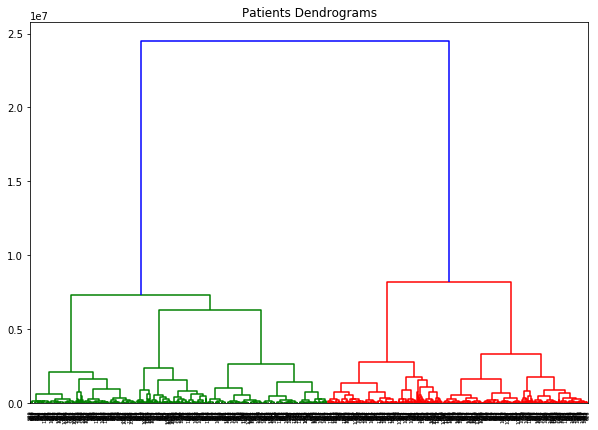

In [17]:
plt.figure(figsize=(10, 7))
plt.title("Patients Dendrograms")
dend = shc.dendrogram(shc.linkage(df, method='ward'))

## Agglomerative Clustering

In [18]:
cluster= AgglomerativeClustering(n_clusters=3, affinity='euclidean',linkage='ward')
cluster.fit_predict(df)
print(cluster.labels_)

[0 0 2 ... 2 1 0]


## Mean Shift

In [19]:
clf=MeanShift()
clf.fit(df)
labels=clf.labels_
cluster_centers=clf.cluster_centers_
dfcopy['cluster_group']=np.nan
df['cluster_group']=np.nan

In [21]:
for i in tqdm.tqdm(range(len(df))):
    dfcopy['cluster_group'].iloc[i]=labels[i]
    df['cluster_group'].iloc[i]=labels[i]
n_clusters_ =len(np.unique(labels))
print(n_clusters_)

100%|██████████| 1134/1134 [01:27<00:00, 12.93it/s]

4


In [22]:
dfcopy.head()

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate,cluster_group
1032,20050924.0,0,white,nonhispanic,1,0.0,334857.07,2949.00,181.4,112.2,34.1,80.0,109.0,71.0,13.0,0.0
1016,19730910.0,1,white,nonhispanic,0,2635.0,82207.01,4264.81,177.4,89.1,28.3,83.0,120.0,60.0,13.0,0.0
1108,19470312.0,1,white,nonhispanic,1,0.0,1669076.91,6580.28,163.3,74.9,28.1,72.0,124.0,90.0,14.0,1.0
70,19400405.0,1,white,nonhispanic,0,0.0,1075827.73,11495.18,129.0,15.2,15.5,81.0,117.0,64.0,12.0,1.0
804,19720324.0,1,white,nonhispanic,1,2155.0,1217204.59,4569.60,173.9,92.3,30.5,77.0,122.0,64.0,12.0,1.0


### Analyzing Groups

In [23]:
temp0=dfcopy[dfcopy['cluster_group']==0]
len(temp0)

452

In [24]:
temp1=dfcopy[dfcopy['cluster_group']==1]
len(temp1)

426

In [25]:
temp2=dfcopy[dfcopy['cluster_group']==2]
len(temp2)

249

In [26]:
temp3=dfcopy[dfcopy['cluster_group']==3]
len(temp3)

7

#### Looking at Outlier Group

In [27]:
temp3.head(7)

,BIRTHDATE,MARITAL,RACE,ETHNICITY,GENDER,ZIP,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,Body Height,Body Weight,Body Mass Index,Diastolic Blood Pressure,Systolic Blood Pressure,Heart rate,Respiratory rate,cluster_group
1000,19140906.0,0,white,nonhispanic,1,0.0,2145924.40,3559.68,133.9,24.7,17.5,80.0,123.0,79.0,15.0,3.0
753,19130530.0,1,black,nonhispanic,1,2115.0,1865296.72,32608.76,161.9,70.4,29.1,73.0,109.0,77.0,15.0,3.0
738,19130530.0,0,black,nonhispanic,1,2128.0,1901642.45,927873.53,168.4,84.3,26.6,85.0,129.0,83.0,15.0,3.0
460,19130530.0,1,black,nonhispanic,1,2118.0,1521294.16,350569.24,114.5,47.7,21.7,82.0,124.0,87.0,14.0,3.0
943,19170507.0,1,white,nonhispanic,1,1950.0,1845466.08,264512.97,146.8,21.8,15.2,85.0,131.0,68.0,13.0,3.0
449,19130530.0,0,black,nonhispanic,1,2151.0,1781146.07,178381.96,153.8,71.7,30.3,85.0,139.0,72.0,16.0,3.0
377,19230622.0,0,white,nonhispanic,1,0.0,1689533.55,612223.87,165.8,82.5,28.5,79.0,111.0,92.0,12.0,3.0


# PCA for Data Visualization

In [28]:
pca=PCA(n_components=3)
principalComponents=pca.fit_transform(df)
principalDF = pd.DataFrame(data=principalComponents, columns =['Principal Component 1', 'Principal Component 2','Principal Component 3'])
principalDF.head()

,Principal Component 1,Principal Component 2,Principal Component 3
0,-507865.335206,-125092.547299,3501.854393
1,-630320.209420,263561.360840,-10511.132569
2,945467.723463,-57223.246763,-18471.686310
3,415886.645658,219180.073965,-17573.307458
4,434284.908076,-130070.824800,-9305.247450


In [29]:
finalDF=pd.concat([principalDF, df[['cluster_group']]],axis=1)
finalDF.head()

,Principal Component 1,Principal Component 2,Principal Component 3,cluster_group
0,-507865.335206,-125092.547299,3501.854393,0.0
1,-630320.209420,263561.360840,-10511.132569,2.0
2,945467.723463,-57223.246763,-18471.686310,2.0
3,415886.645658,219180.073965,-17573.307458,2.0
4,434284.908076,-130070.824800,-9305.247450,NaN


### 2D

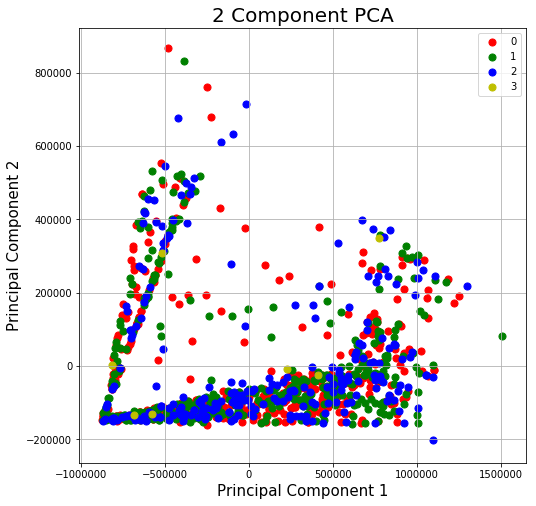

In [30]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0,1,2,3]
colors = ['r', 'g', 'b','y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDF['cluster_group'] == target
    ax.scatter(finalDF.loc[indicesToKeep, 'Principal Component 1']
               , finalDF.loc[indicesToKeep, 'Principal Component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### 3D

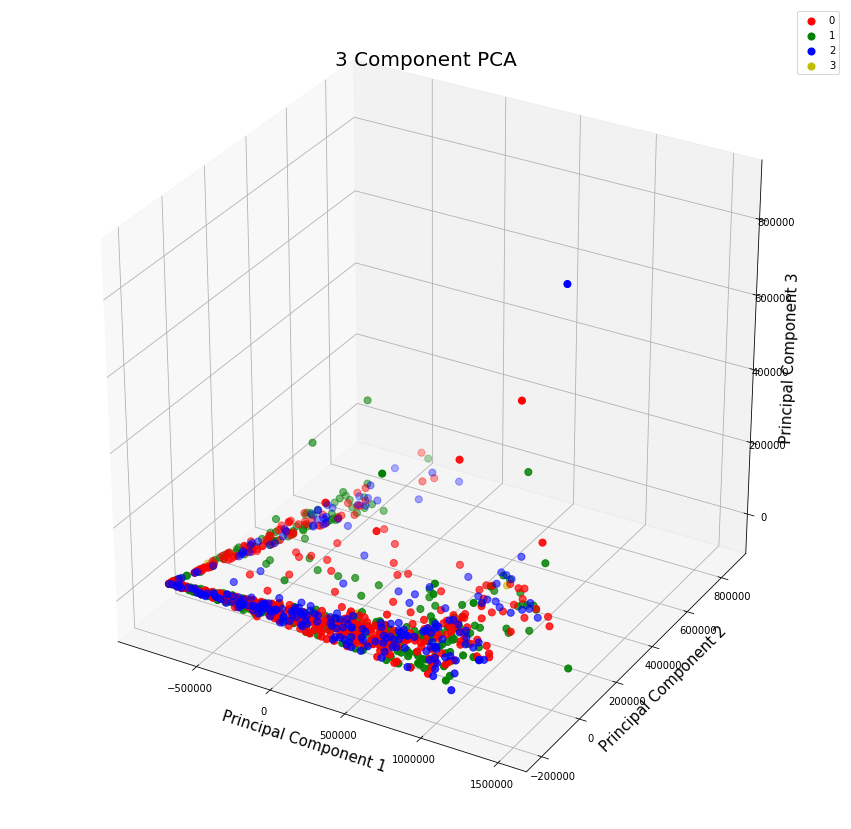

In [31]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111,projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 Component PCA', fontsize = 20)


targets = [0,1,2,3]
colors = ['r', 'g', 'b','y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDF['cluster_group'] == target
    ax.scatter(finalDF.loc[indicesToKeep, 'Principal Component 1']
               , finalDF.loc[indicesToKeep, 'Principal Component 2']
               , finalDF.loc[indicesToKeep, 'Principal Component 3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()